One important issue that was evident to us (NFQ Solutions) during the last two months is that the Pandas Dataframe is not a very good container for data. This notebook is a short explanation on why we may have to reduce our now intensive use of the Pandas Dataframe (it is now almost everywhere) and to explore some other solutions. None of this is a criticism about Pandas. It is a game changer, and I am a strong advocate for its use. It's just that we hit one of its limitations. Some simple operations just have too much overhead.

To be more precise, let's start by importing Pandas

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'a': np.arange(1E6), 'b': np.arange(1E6)})

We have just created a relatively large dataframe with some dummy data, enough to prove my initial point. Let's see how much time it takes to add the two columns and to insert the result into the third one.

In [2]:
%%timeit
df.c = df.a + df.b

2.29 ms ± 6.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Is that fast or slow? Well, let's try to make the very same computation in a slightly different manner

In [3]:
a = df.a.values
b = df.b.values

In [4]:
%%timeit
c = a + b

2 ms ± 9.24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


If we compare how fast it is to a simple sum of two numpy arrays, it is pretty fast. But we are adding two relatively large arrays. Let's try the exact same thing with smaller arrays.

In [5]:
df = pd.DataFrame({'a': np.arange(100), 'b': np.arange(100)})

In [6]:
%%timeit
df.c = df.a + df.b

156 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
a = df.a.values
b = df.b.values

In [8]:
%%timeit
c = a + b

905 ns ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Now things have changed quite a lot. Just adding two arrays takes two orders of magnitude less than adding from the Pandas Dataframe. But this comparison is not fare at all. Those 145µs are not spent waiting. Pandas does lots of things with the value of the Series resulting from the sum before it inserts it to the dataframe. If we profile the execution of that simple sum, we'll see that almost a fifth of the time is spent on a function called `_sanitize_array`.

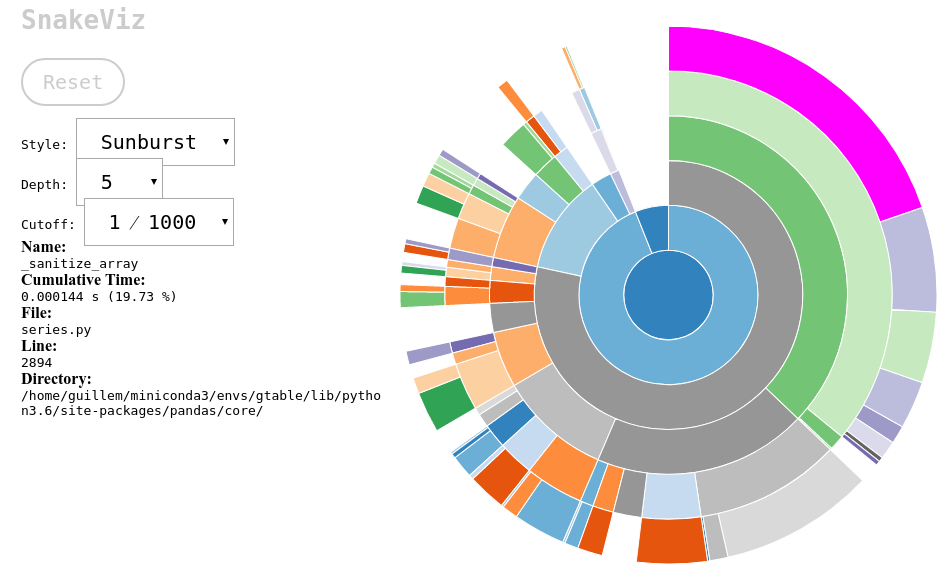

In [9]:
from IPython.display import Image
Image(filename='snakeviz_add.png') 

The most important characteristic of Pandas is that it always does what it is supposed to do with data regardless of how dirty, heterogeneous, sparse (you name it) your data is. And it does an amazing job with that. But the price we have to pay are those two orders of magnitude in time.

That is exactly what impacted the performance of our last project. The Dataframe is a very convenient container because it always does something that makes sense, therefore you have to code very little. For instance, take the `join` method of a dataframe. It does just what it has to do, and it is definitely not trivial. Unfortunately, that overhead is too much for us.

We are in the typical situation where abstractions are not for free. The higher the level, the slower the computation. This is a kind of a *second law of Thermodynamics* applied to numerical computing. And there are abstractions that are tremendously useful to **us**. A Dataframe is not a dictionary of arrays. It can be indexed by row and by column, and it can operate as a whole, and on any imaginable portion of it. It can sort, group, joing, merge... You name it. But if you want to compute the payment schedule of all the securities of an entire bank, you may need thousands of processors to have it done in less than six hours.

This is where I started thinking. There must be something in between. Something that is fast, but it's not just a dictionary of numpy arrays. And I started designing gtable

In [10]:
from gtable import Table

tb = Table({'a': np.arange(1E6), 'b': np.arange(1E6)})

In [11]:
%%timeit
tb.c = tb.a + tb.b

3.04 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


You can see that for large arrays, the computation time shadows the overhead. Let's see how well it does with smaller arrays

In [12]:
tb = Table({'a': np.arange(100), 'b': np.arange(100)})

In [13]:
%%timeit 
tb.c = tb.a + tb.b

95.3 µs ± 3.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


We have improved by a factor of 7, which is crucial if that's the difference between running in one or seven servers. We can still improve the computation by a little bit more if we use reuse a slot and we avoid some memory allocations.

In [14]:
%%timeit
tb.a = tb.a + tb.b

91.9 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Of course, these speedups come at a cost: features. Gtable is in its infancy. There are literally two afternoons of work on it, and the whole module fits within a single file with less than 300 lines of code. It is pure python, and I have not started to seriously tune its performance. But the idea of having something inbetween a Dataframe and a dictionary of arrays with support for sparse information is appealing to say the list.

Let me demo a little the capabilities of this tiny module of mine. Assume that we start with a small table with two columns

In [15]:
tb = Table({'a': pd.date_range('2000-01-01', freq='M', periods=10),
            'b': np.random.randn(10)})
tb

<Table[ a[10] <object>, b[10] <float64> ] object at 0x7f28130cfb00>

In [16]:
tb.hcat('schedule', np.array(['first ']))
tb

<Table[ a[10] <object>, b[10] <float64>, schedule[1] <<U6> ] object at 0x7f28130cfb00>

I have been able to concatenate a full column in the horizontal direction with a single value, and it's part of the information that the printed value of the table gives. Storing the data and the indexes separately is a nice and efficient way of dealing with sparse data. We can visualize the table by converting it to a pandas Dataframe

In [17]:
tb.to_pandas()

,a,b,schedule
0,2000-01-31,0.491673,first
1,2000-02-29,-0.609956,NaN
2,2000-03-31,1.522488,NaN
3,2000-04-30,0.087832,NaN
4,2000-05-31,0.460084,NaN
5,2000-06-30,0.700202,NaN
6,2000-07-31,-1.118937,NaN
7,2000-08-31,0.413834,NaN
8,2000-09-30,-0.174966,NaN
9,2000-10-31,1.512022,NaN


Gtable is not designed as a general tool for data analysis, but as an efficient data container. We can also concatenate data in the vertical direction efficiently, also keeping a single copy of data when necessary

In [18]:
tb1 = tb.copy()
tb1.schedule.values[0] = 'second'
tb.vcat(tb1)
tb.to_pandas()

,a,b,schedule
0,2000-01-31,0.491673,first
1,2000-02-29,-0.609956,NaN
2,2000-03-31,1.522488,NaN
3,2000-04-30,0.087832,NaN
4,2000-05-31,0.460084,NaN
5,2000-06-30,0.700202,NaN
6,2000-07-31,-1.118937,NaN
7,2000-08-31,0.413834,NaN
8,2000-09-30,-0.174966,NaN
9,2000-10-31,1.512022,NaN


If you care a little about how it is done. The internal storage is just an OrderedDict of arrays and a bitmap index. The bitmap index is interesting because some computations, like sorting or filtering, only involve the index. The storage of the table is stored within the `_data` and `_index` attributes

In [19]:
tb._data

OrderedDict([('a',
              array(['2000-01-31T00:00:00.000000000', '2000-02-29T00:00:00.000000000',
                     '2000-03-31T00:00:00.000000000', '2000-04-30T00:00:00.000000000',
                     '2000-05-31T00:00:00.000000000', '2000-06-30T00:00:00.000000000',
                     '2000-07-31T00:00:00.000000000', '2000-08-31T00:00:00.000000000',
                     '2000-09-30T00:00:00.000000000', '2000-10-31T00:00:00.000000000',
                     '2000-01-31T00:00:00.000000000', '2000-02-29T00:00:00.000000000',
                     '2000-03-31T00:00:00.000000000', '2000-04-30T00:00:00.000000000',
                     '2000-05-31T00:00:00.000000000', '2000-06-30T00:00:00.000000000',
                     '2000-07-31T00:00:00.000000000', '2000-08-31T00:00:00.000000000',
                     '2000-09-30T00:00:00.000000000', '2000-10-31T00:00:00.000000000'], dtype='datetime64[ns]')),
             ('b',
              array([ 0.49167292, -0.60995618,  1.52248828,  0.08

In [20]:
tb._index

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

We can take some advantage of knowing the internal representation of the data to insert data into the table in an efficient way. Every attribute of the table corresponds to a column, and each column stores the data as a numpy array in `values` and a piece of the index in `index`. 

In [21]:
b_col = tb.b
b_col

<Column[ float64 ] object at 0x7f27e0be29b0>

This means that it is relatively simple make efficient computations with a whole column, to add yet another colum

In [22]:
tb.sum_b = b_col.values.cumsum()

In [23]:
tb.sum_b.values

array([ 0.49167292, -0.11828327,  1.40420502,  1.49203713,  1.95212094,
        2.65232314,  1.53338648,  1.94722069,  1.77225518,  3.28427759,
        3.77595051,  3.16599433,  4.68848261,  4.77631472,  5.23639853,
        5.93660073,  4.81766407,  5.23149828,  5.05653278,  6.56855518])

We'll see where it will go from here